In [1]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
%matplotlib notebook

In [3]:
def cost_for(x1, x2, z, f):
    Nx_p = np.shape(x1)[1]
    x_plot = np.vstack((x1,x2))
    print(np.shape(z))
    for i in range(Nx_p):
        z[:,i] = f(x_plot[:,i])

In [4]:
def plot_init(G, c, x1_range = None, x2_range = None, z_range = None):
    if x1_range is None:
        x1_val  = np.arange(-5, 5, 0.1, dtype=np.float32)
    else:
        x1_val = x1_range
    if x2_range is None:
        x2_val = np.arange(-5, 5, 0.1, dtype=np.float32)
    else:
        x2_range = x2_val
    G = ca.DM(G).full()
    c = ca.DM(c).full()
    x1_val_mesh, x2_val_mesh = np.meshgrid(x1_val, x2_val)
    x1_val_mesh_flat = x1_val_mesh.reshape([1, -1])
    x2_val_mesh_flat = x2_val_mesh.reshape([1, -1])

    z_val_mesh_flat = np.zeros_like(x1_val_mesh_flat)
    f = lambda x: x.T @ G @ x + c @ x
    cost_for(x1_val_mesh_flat,x2_val_mesh_flat,z_val_mesh_flat,f)

    # z_val_mesh = np.reshape([(lambda x1,x2: (x1-1)**2 + (x2-2.5)**2)(x1,x2) for x1,x2 in zip(x1_val_mesh_flat,x2_val_mesh_flat)],(x1_val_mesh.shape))
    z_val_mesh = np.reshape(z_val_mesh_flat,(x1_val_mesh.shape))

    
    fig = plt.figure(figsize=(6, 4))
    spec=fig.add_gridspec(nrows=1,ncols=1)
    ax1 = fig.add_subplot(spec[0,0],projection='3d' )
    ax1.plot_surface(x1_val_mesh, x2_val_mesh, z_val_mesh, alpha=0.5, cmap=cm.coolwarm)

    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('Z')
    return ax1

In [5]:
def random_update(x0, f_func, N_step = 0):
        x_update = []
        f_update = []
        
        xk = x0
        x_update += xk
        fk = f_func.f(xk).full().flatten().tolist()
        f_update += fk
        for i in range(N_step):
            p_rand = 2* np.random.rand(2) - 1
            xk = xk + p_rand
            fk = f_func.f(xk).full().flatten().tolist()
            f_update += fk
            x_update += xk.tolist()
        return x_update,f_update

In [6]:
def update_plot(ax, x0, x_update, f_update):
    
    Ni = np.shape(x0)[0]    
    N_plot = np.shape(f_update)[0]
    f_value = f_update[0]
    plot_cache = None
    for n_plot in range(N_plot):
        xk = x_update[Ni * n_plot:Ni * (n_plot + 1)]
        print(xk)
        if n_plot == 0:
            plot_cache = ax.scatter(xk[0], xk[1], f_value, s=20, depthshade=True, color='r')
            x_past = xk
            f_past = f_value
        else:
            f_value = f_update[n_plot]
            plot_cache.remove()
            plot_cache = ax.scatter(xk[0], xk[1], f_value, s=20, depthshade=True, color='r')
            ax.plot([x_past[0], xk[0]], [x_past[1], xk[1]], [f_past, f_value], linewidth=2, color='r')

            x_past = xk
            f_past = f_value  

In [7]:
class func:
    def __init__(self, G, c):
        Nx = G.shape[0]
        x = ca.SX.sym('x', Nx)
        p = ca.SX.sym('p', Nx)
        t = ca.SX.sym('t', 1)
        f = ca.Function('f', [x], [ x.T @ G @ x + c @ x])
        self.f = f
        Jac = ca.jacobian(f(x),x)
        Jac_func = ca.Function('jacobian',[x],[Jac])
        Hessian = ca.hessian(f(x),x)[0]
        Hessian_func = ca.Function('Hessian',[x],[Hessian])
        f_update_taylor = f(x) + Jac @ p + 1/2 * p.T @ Hessian_func(x + t*p) @ p
        f_update_taylor_func = ca.Function("f_update_func", [t,x,p],[f_update_taylor])
        self.f_update_taylor_func = f_update_taylor_func
        
        f_update_real = f(x + p)
        f_update_real_func = ca.Function("f_update_func", [x,p],[f_update_real])
        self.f_update_real_func = f_update_real_func
        

### Random update: test 1 saddle point

In [8]:
G = ca.SX([[10,0],[0,-5]])
c = ca.SX([0,0]).T
x0 = [0,0]

f_func = func(G, c)

x_update,f_update = random_update(x0, f_func, N_step = 20)

(1, 10000)


<IPython.core.display.Javascript object>


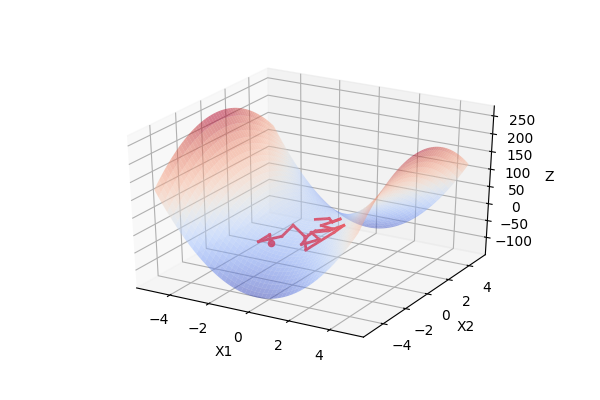

[0, 0]
[0.5173645022169779, 0.30440659074350473]
[1.0371243560446972, -0.3132006153531002]
[1.2602370131268843, -0.04093438556571338]
[0.6700636219057163, -0.6417649258004285]
[1.6063797646225113, -1.3281242381130305]
[0.6953348457721327, -1.1905576713431574]
[0.545109268570025, -1.5747684758653988]
[0.5996039069677868, -2.233468066443721]
[1.3808973472030015, -2.0474018641457548]
[0.5528848517368024, -1.3144050655082342]
[1.4794600602908337, -1.4090500017210508]
[2.343440937719654, -1.6447159471837978]
[2.0070426367438925, -1.8865421262549351]
[1.0541656111216349, -2.6354856522026884]
[0.414516481557635, -1.6451170651869724]
[-0.5162561399478471, -1.0356456857510785]
[-0.5365894587821283, -1.9681983003360533]
[-1.2327677366752257, -2.781238152544484]
[-1.02449845218433, -2.1720713768792015]
[-0.7736993546657138, -2.5336396776957386]


In [9]:
ax1 = plot_init(G,c)
update_plot(ax1,x0,x_update,f_update)

### Random update: test 2 optimal point

In [10]:
G = ca.SX([[10,0],[0,10]])
c = ca.SX([0,0]).T
x0 = [0,0]

f_func = func(G, c)

x_update,f_update = random_update(x0, f_func, N_step = 20)

(1, 10000)


<IPython.core.display.Javascript object>


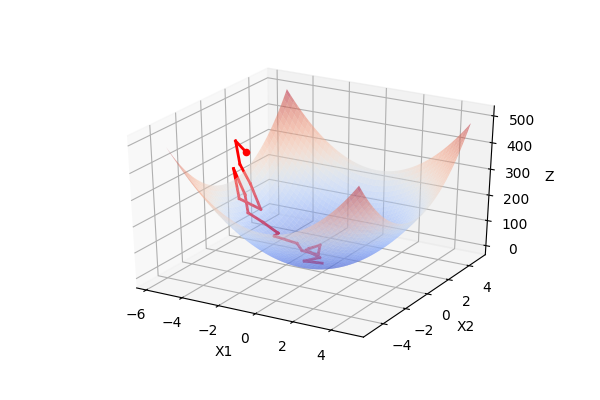

[0, 0]
[-0.7642598725069583, -0.36004474589891267]
[-0.41427730337295543, 0.45359596738378727]
[-1.2275488194156783, 0.5637819727605915]
[-1.202512586144228, 0.7590665883625107]
[-0.9041805376395666, 1.2634834085719227]
[-0.6012200895533255, 0.6155593186309034]
[-1.3546841253743034, 0.38593574503158146]
[-1.7809493221930648, 0.631158084512963]
[-2.6375392952361776, -0.006411586558612958]
[-2.6495129382173337, 0.3509241254910771]
[-3.3246247815934113, 0.11404292227712975]
[-3.883667171066605, -0.30579465057003463]
[-4.447652414681521, 0.32165556381436344]
[-5.262769013397547, 0.6327566508873088]
[-4.43004367301758, -0.20039721508638486]
[-3.753960752781374, 0.5797548438381499]
[-4.593099920589818, 1.0165826444919723]
[-5.231161279639946, 1.1251050321894265]
[-5.761312143866631, 1.602180734753942]
[-5.32447336573405, 1.806210144709775]


In [11]:
ax1 = plot_init(G,c)
update_plot(ax1,x0,x_update,f_update)